In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datetime import datetime

# yahoo Finance API library (useful?)
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as pdr
yf.pdr_override()

Analysis for 2 groups with a focus to see if there is a connection between these companies and if they are worth investing into
Amazon, Google, Microsoft - The usual big 3, how connected are they
Nvidia, AMD, Intel - Microcontrollers and AI boom

Desire to invest into Microsoft, Amazon, Intel, Goldman Sachs, and Apple as my trades

In [29]:
cpu_list = ['NVDA', 'INTC','AMD']

comp_list = ['MSFT','AMZN', 'GOOG', 'AAPL']

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

In [30]:
for stock in cpu_list:
    globals()[stock] = yf.download(stock, start, end)

df_nvda = globals()['NVDA']
df_amd = globals()['AMD']
df_intc = globals()['INTC']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [31]:
for stock in comp_list:
    globals()[stock] = yf.download(stock, start, end)

df_msft = globals()['MSFT']
df_amzn = globals()['AMZN']
df_goog = globals()['GOOG']
df_aapl = globals()['AAPL']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [52]:
globals()['GS'] = yf.download('GS', start, end)
df_gs = globals()['GS'] 

[*********************100%%**********************]  1 of 1 completed


#### Model Preparation 

Spreads data to five years instead of 3 years

In [ ]:
def preprocess_data(stock_symbol, epochs=100, batch_size=32, window_size=60):
    # Fetch data
    end = datetime.now()
    start = datetime(end.year - 5, end.month, end.day)
    df = pdr.get_data_yahoo(stock_symbol, start=start, end=end)

    data = df.filter(['Close'])
    dataset = data.values
    training_data_len = int(np.ceil(len(dataset) * .95))

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset)

    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i+window_size])
        y.append(scaled_data[i+window_size])

    X, y = np.array(X), np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Make predictions
    test_data = scaled_data[training_data_len - window_size:, :]
    test_set = []
    for i in range(window_size, len(test_data)):
        test_set.append(test_data[i-window_size:i, 0])

    test_set = np.array(test_set)
    test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1))

    prediction = model.predict(test_set)
    scaled_pred = scaler.inverse_transform(prediction)

    # Prepare results
    valid = data[training_data_len:]
    valid['Predictions'] = scaled_pred

    return df, valid, model.predict(X_test)

## Analysis of Intel, Nvidia, and AMD - Chip Industry

### Closing Prices

In [ ]:
col_nvda = df_nvda['Adj Close']
col_amd = df_amd['Adj Close']
col_intc = df_intc['Adj Close']

col_df = pd.concat([col_nvda, col_amd, col_intc], axis=1)
col_df.columns = ['NVDA', 'AMD', 'INTC']

#### Performance Summary

In [ ]:
fig = px.line(col_df, y=['NVDA', 'AMD', 'INTC'], title = 'Closing Prices of Stocks')
fig.show()

To be seen in the chart above, Nvidia's stock performance feels unnatural considering the stock performance of chipmaker companies. There is a possibility that Nvidia's stock may drop once it reaches the 1k dollar peak considering how close it is.

#### Individual Performance

In [ ]:
fig_nvda = px.line(df_nvda, y=['Adj Close'], title='Nvidia Stock Performance')

fig_amd = px.line(df_amd, y=['Adj Close'], title='AMD Stock Performance')

fig_intc = px.line(df_intc, y=['Adj Close'], title='Intel Stock Performance')

In [ ]:
fig_nvda.show()
fig_amd.show()
fig_intc.show()

It can be seen that there are certain drops in stock price for each company on the same day. Such as March 7th 2024, where each stock had its price experience a suddden spike in the semiconductor industry when Broadcom (AVGO) had its price target raised. 

It can be noticed that any annoucement in the industry can deeply affect other stock prices.

### Simple Moving Average (SMA)

Moving Average is used to smooth out the price data by creating an updated average price. Allowing us to see if the stock is going below the average due to fluctuations or random impacts in a certain time frame.

100 days can be used to represent a smaller price compared to the rest of the year. 

50 days represent a level that the stock is best to go under. 

10 days represent a close following of the stock and capture trends.

In [ ]:
ma_day = [10, 50, 100]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_nvda[column_name] = df_nvda['Adj Close'].rolling(ma).mean()
    df_amd[column_name] = df_amd['Adj Close'].rolling(ma).mean()
    df_intc[column_name] = df_intc['Adj Close'].rolling(ma).mean()


Text(0.5, 1.0, 'Intel Moving Average')

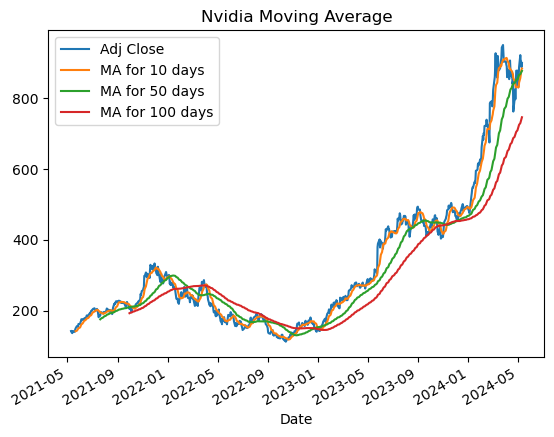

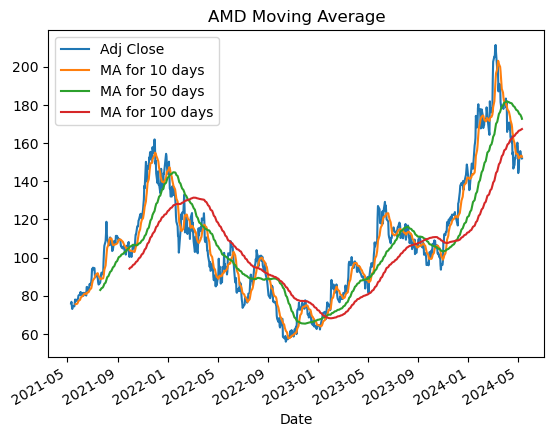

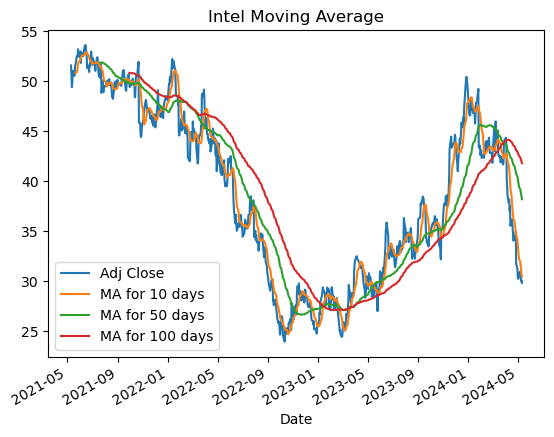

In [ ]:
df_nvda[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Nvidia Moving Average")

df_amd[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("AMD Moving Average")

df_intc[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Intel Moving Average")

### Volatility Calculation

Volatility Calculation measures the change in variance in a stock's return. This can be used to compare the level of risk for stocks and comparison.

In [ ]:
min_periods = 75
vol_nvda = df_nvda['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)
vol_amd = df_amd['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)
vol_intc = df_intc['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)

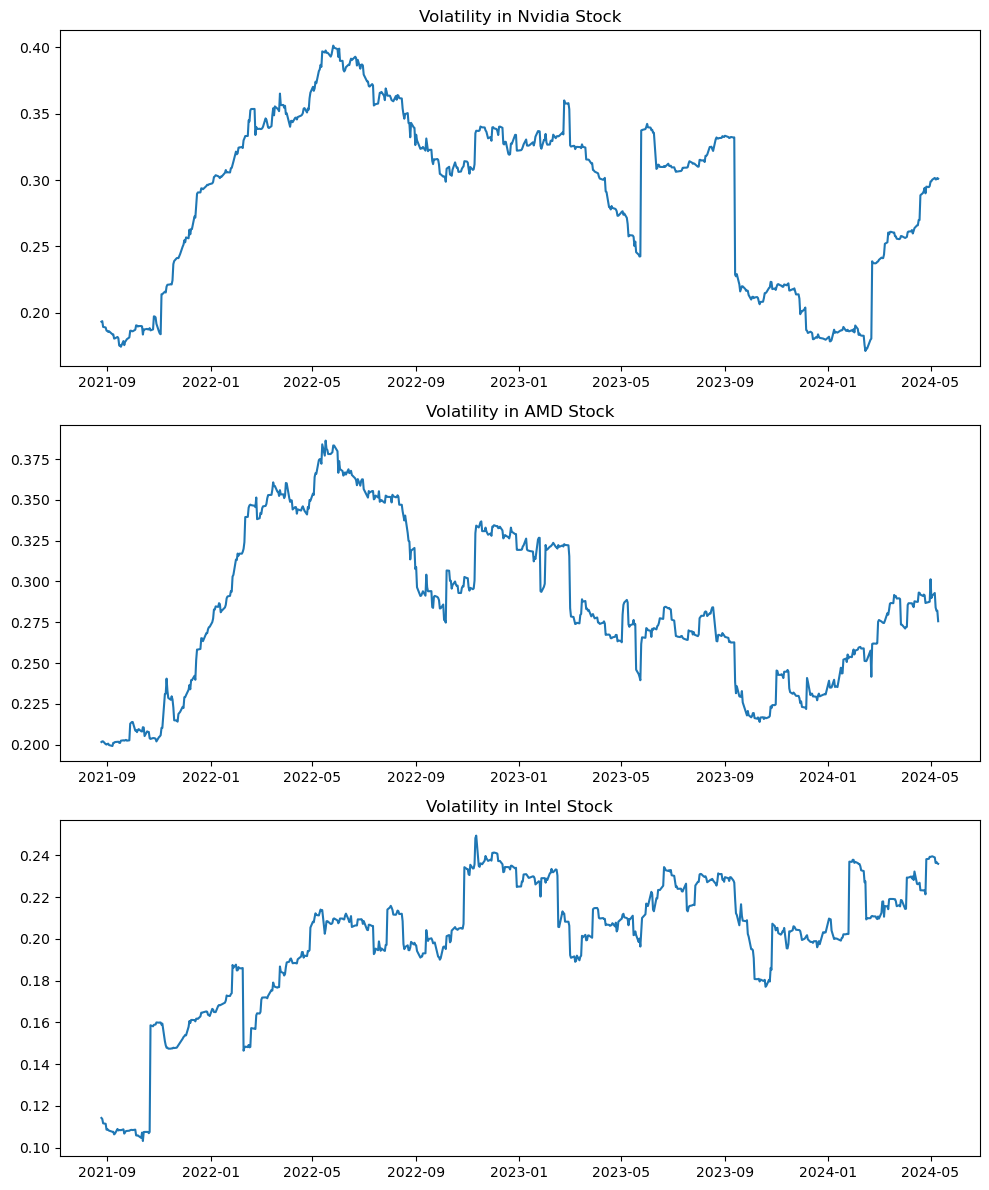

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10,12))

axs[0].plot(vol_nvda)
axs[0].set_title('Volatility in Nvidia Stock')

axs[1].plot(vol_amd)
axs[1].set_title('Volatility in AMD Stock')

axs[2].plot(vol_intc)
axs[2].set_title('Volatility in Intel Stock')

plt.tight_layout()
plt.show()

Based on the Volatiliy charts, it can be seen the correlation that the 3 companies may have. Although Intel does not seem as closely reactive as compared to the similar points of rise and falls that Nvidia and AMD have. 

The most notable point of correlation is 2022-01 to 2022-09 where we can see a noticeable rise and in stock volatility and then seeing it significantly fall around the same time for both. There is a better seen correlation between AMD and Intel in certain points in time as well such as 2023-05 to 2023-09 as well.

But overall between all three companies, we can see points in time where each stock would have a significant rise or drop in their own way at the same time such as 2023-09 for each company. 

Nvidia is seen to have the worst volatility out of the three available stocks with its sudden drops and rises. 

### Prediction

#### Nvidia Prediction

In [ ]:
df_nvda_5, valid_nvda, pred_nvda = preprocess_data(cpu_list[0])

[*********************100%%**********************]  1 of 1 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


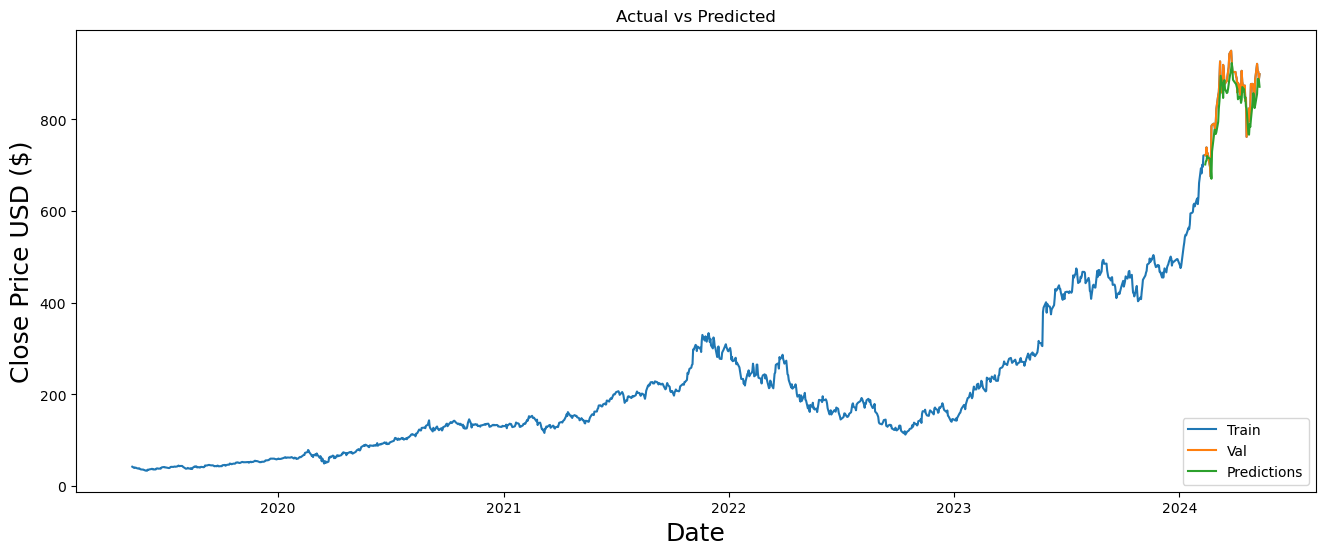

In [ ]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_nvda_5['Close'])
plt.plot(valid_nvda[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_nvda_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_nvda[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

Consider selling the stock.


#### AMD Prediction

In [ ]:
df_amd_5, valid_amd, pred_amd = preprocess_data(cpu_list[2])

[*********************100%%**********************]  1 of 1 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


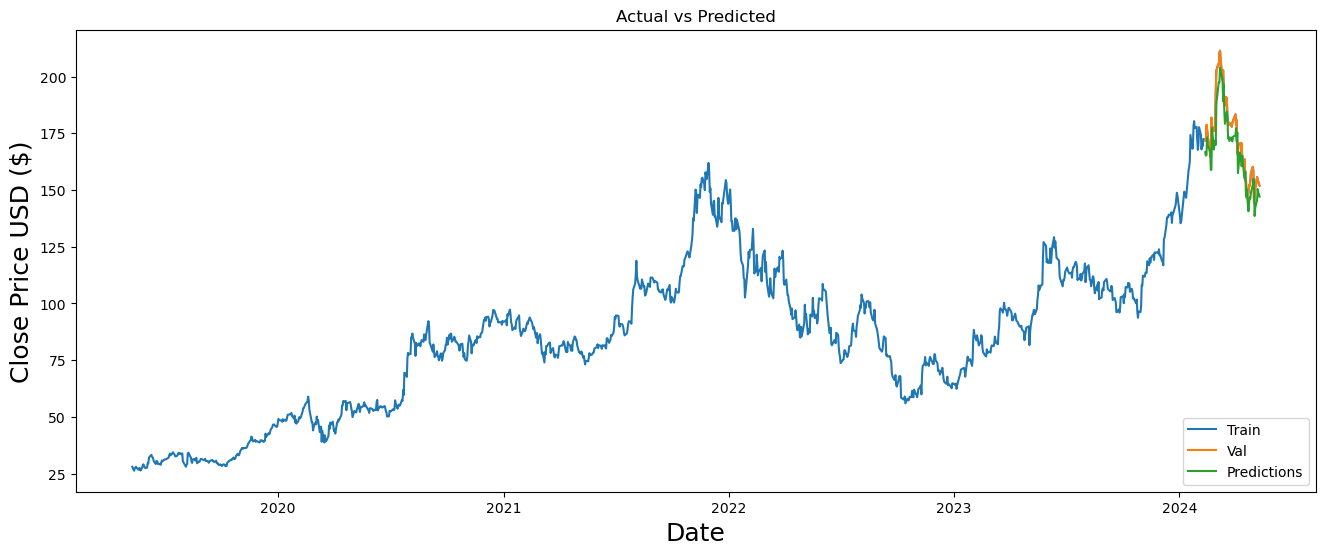

In [ ]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_amd_5['Close'])
plt.plot(valid_amd[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_amd_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_amd[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

Consider selling the stock.


#### Intel Prediction

In [ ]:
df_intc_5, valid_intc, pred_intc = preprocess_data(cpu_list[1])

[*********************100%%**********************]  1 of 1 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


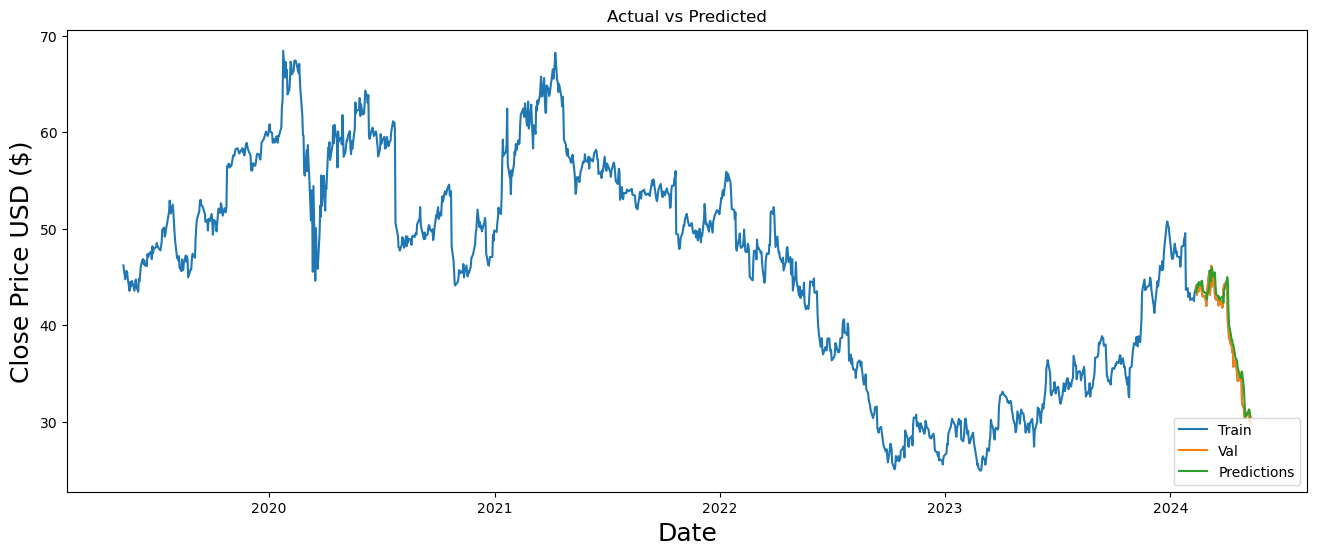

In [ ]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_intc_5['Close'])
plt.plot(valid_intc[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_intc_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_intc[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

Consider selling the stock.


### Conclusion

When analyzing the correlation between the three stocks and their performance, Nvidia is no longer a good choice for futher investment considering its ever increasing price, instead it may be preferrable to sell the stock or keep in hopes of a better return. A return in investment would be seen but consideirng its unnatural rise and how close it is to reaching $1000 dollars, there is a possibility that most would sell and thus causing the stock to drop to a more investable level. 

AMD and Intel are not as well performing as compared to Nvidia but hold a more reasonable price and promise. Among both AMD and Intel, Intel does not show the same promise it used to have 3 years before, reaching the lowest it has ever been within the last 5 years. Compared to its competitors, Intel does not have a strong foothold in the Chipmaker market as compared to Nvidia and AMD and has been struggling to recover or even catch up to AMD.

This leads to the conclusion following predictions and stock history, that AMD may be a wise further investment strategy. Considering its still viable position in the Chip market and how close its performance in stock volatility it is to Nvidia. It has the capability to rise higher in stock price and provide a return in investment. Whenever Nvidia will experience a significant rise in the market, AMD will also feel it as well. Although the same can go for Intel, its performance proves it struggles to return to the glory it used to have in the market.

## Analysis of Apple, Google, Microsoft, and Amazon - The Popular Staple Tech Companies

### Closing Prices

In [33]:
col_msft = df_msft['Adj Close']
col_amzn = df_amzn['Adj Close']
col_goog = df_goog['Adj Close']
col_aapl = df_aapl['Adj Close']

col_df = pd.concat([col_msft,col_amzn,col_goog,col_aapl], axis=1)
col_df.columns = ['MSFT', 'AMZN', 'GOOG', 'AAPL']

#### Performance Summary

In [34]:
fig = px.line(col_df, y=['MSFT','AMZN','GOOG', 'AAPL'], title='Closing Prices of Stocks')
fig.show()

----

#### Individual Performance

In [35]:
fig_msft = px.line(df_msft, y=['Adj Close'], title='Microsoft Stock Performance')

fig_amzn = px.line(df_amd, y=['Adj Close'], title='Amazon Stock Performance')

fig_goog = px.line(df_intc, y=['Adj Close'], title='Google Stock Performance')

fig_aapl = px.line(df_aapl, y=['Adj Close'], title='Apple Stock Performance')

In [36]:
fig_msft.show()
fig_amzn.show()
fig_goog.show()
fig_aapl.show()

-------

### Simple Moving Average (SMA)

Moving Average is used to smooth out the price data by creating an updated average price. Allowing us to see if the stock is going below the average due to fluctuations or random impacts in a certain time frame.

100 days can be used to represent a smaller price compared to the rest of the year. 

50 days represent a level that the stock is best to go under. 

10 days represent a close following of the stock and capture trends.

In [37]:
ma_day = [10, 50, 100]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_msft[column_name] = df_msft['Adj Close'].rolling(ma).mean()
    df_amzn[column_name] = df_amzn['Adj Close'].rolling(ma).mean()
    df_goog[column_name] = df_goog['Adj Close'].rolling(ma).mean()
    df_aapl[column_name] = df_aapl['Adj Close'].rolling(ma).mean()

Text(0.5, 1.0, 'Apple Moving Average')

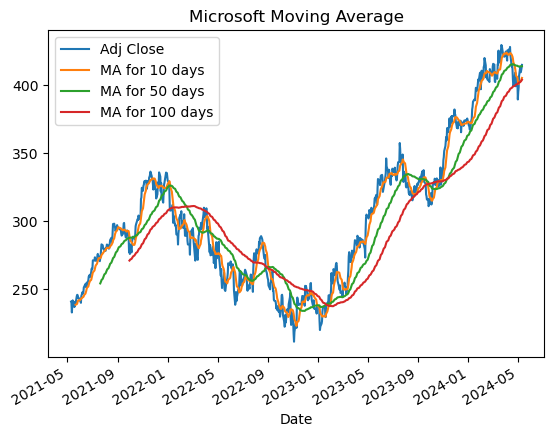

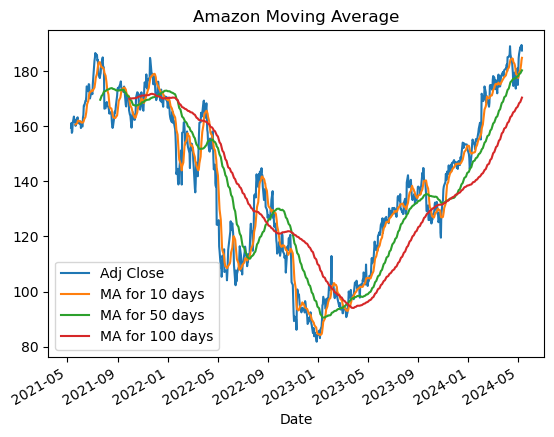

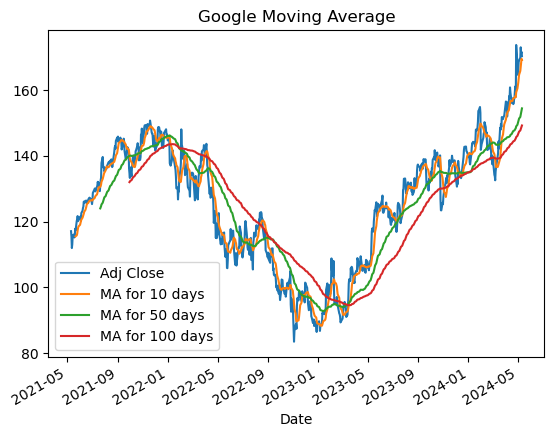

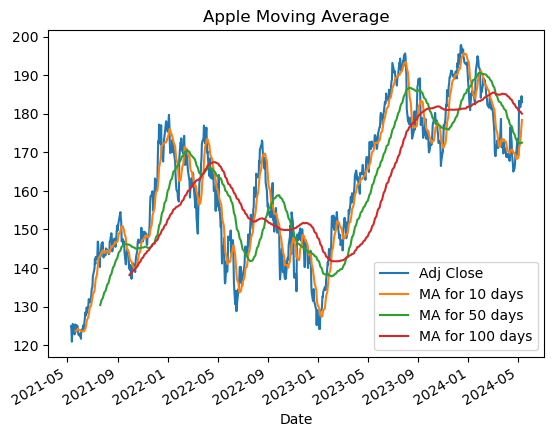

In [38]:
df_msft[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Microsoft Moving Average")

df_amzn[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Amazon Moving Average")

df_goog[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Google Moving Average")

df_aapl[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Apple Moving Average")

### Volatility Calculation

Volatility Calculation measures the change in variance in a stock's return. This can be used to compare the level of risk for stocks and comparison.

In [39]:
min_periods = 75
vol_msft = df_msft['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)
vol_amzn = df_amzn['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)
vol_goog = df_goog['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)
vol_aapl = df_aapl['Adj Close'].pct_change().rolling(min_periods).std() * np.sqrt(min_periods)

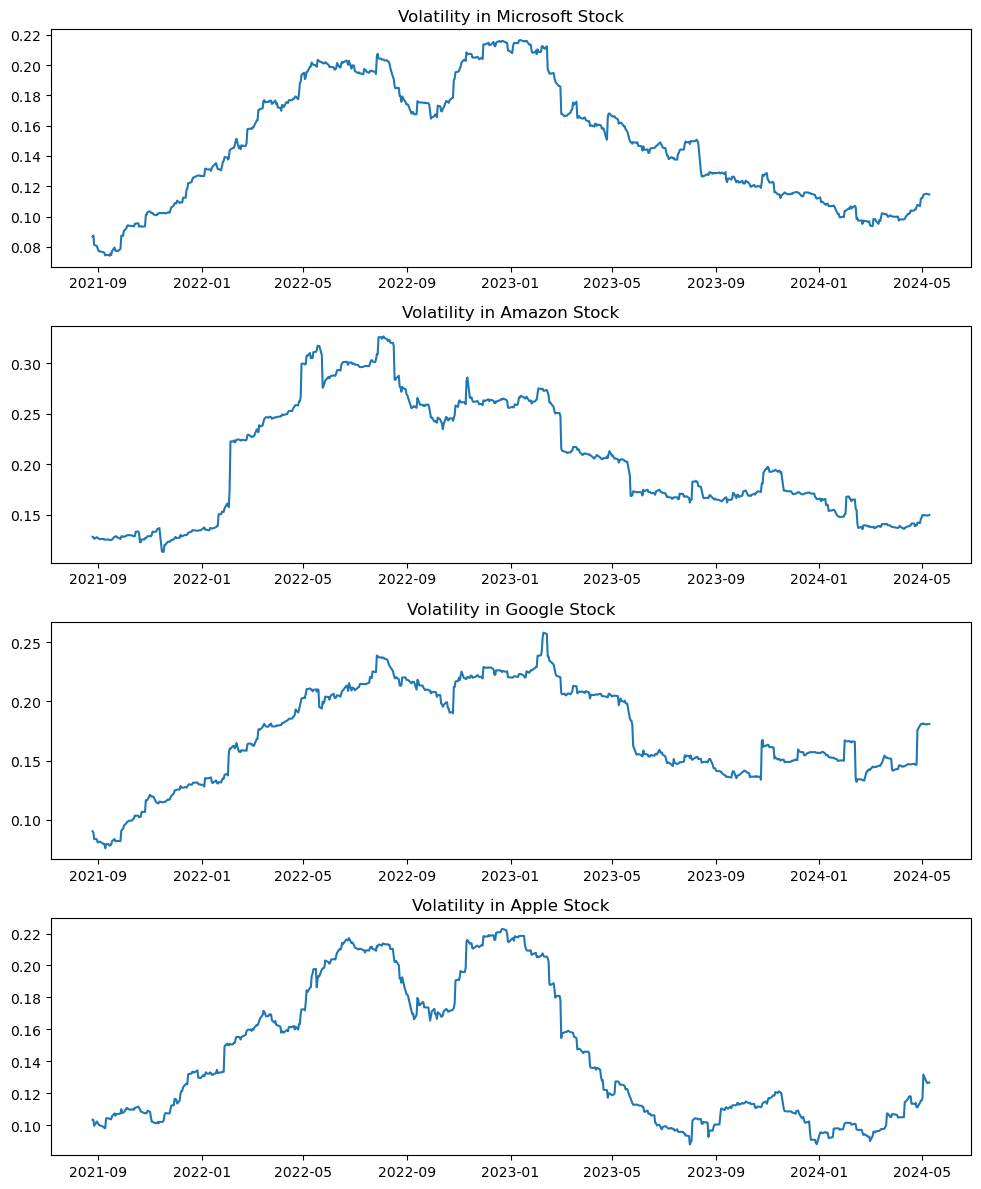

In [41]:
fig, axs = plt.subplots(4, 1, figsize=(10,12))

axs[0].plot(vol_msft)
axs[0].set_title('Volatility in Microsoft Stock')

axs[1].plot(vol_amzn)
axs[1].set_title('Volatility in Amazon Stock')

axs[2].plot(vol_goog)
axs[2].set_title('Volatility in Google Stock')

axs[3].plot(vol_aapl)
axs[3].set_title('Volatility in Apple Stock')

plt.tight_layout()
plt.show()

------

### Risk Level

----

### Prediction

#### Microsoft Prediction

In [42]:
df_msft_5, valid_msft, pred_msft = preprocess_data(comp_list[0])

[*********************100%%**********************]  1 of 1 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


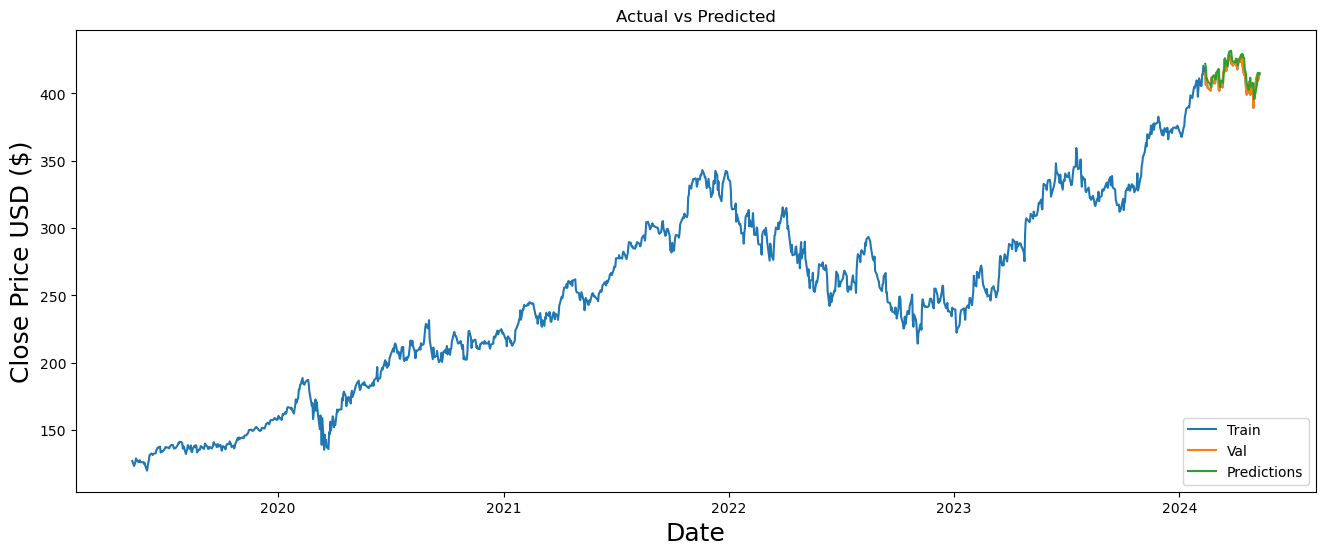

In [43]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_msft_5['Close'])
plt.plot(valid_msft[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [44]:
# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_msft_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_msft[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

Consider selling the stock.


#### Amazon Prediction

In [45]:
df_amzn_5, valid_amzn, pred_amzn = preprocess_data(comp_list[1])

[*********************100%%**********************]  1 of 1 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


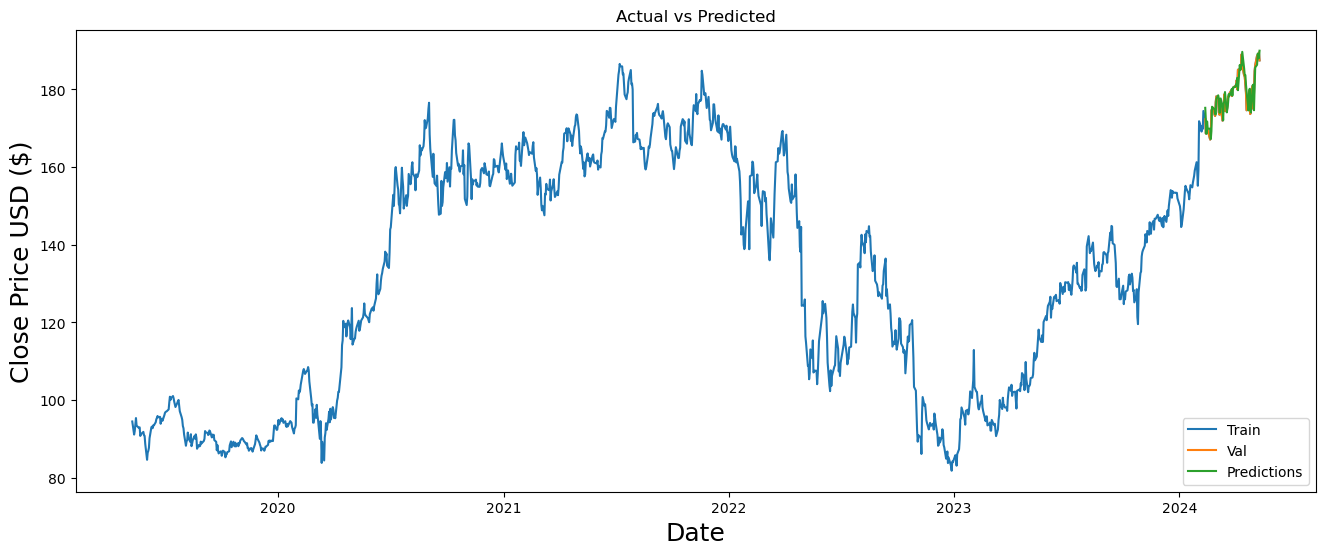

In [46]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_amzn_5['Close'])
plt.plot(valid_amzn[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_amzn_5['Adj Close'].iloc[-1]
print(current_price)
threshold = 0.03

predicted_price = pred_amzn[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

Consider selling the stock.


#### Google Prediction

In [54]:
df_goog_5, valid_goog, pred_goog = preprocess_data(comp_list[2])

[*********************100%%**********************]  1 of 1 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


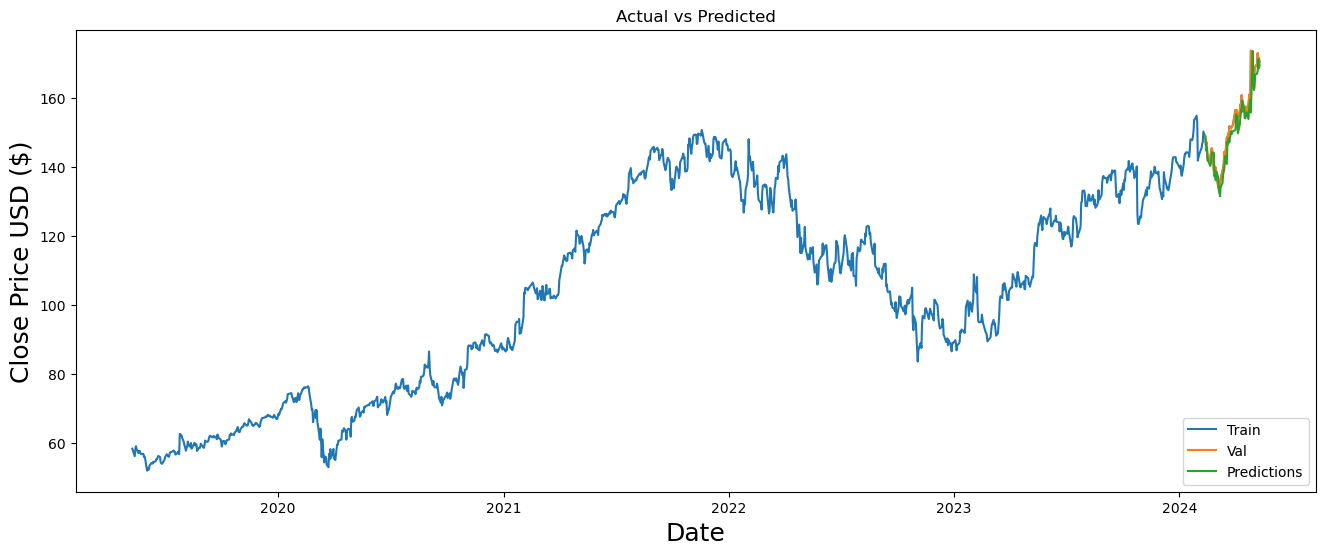

In [55]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_goog_5['Close'])
plt.plot(valid_goog[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [56]:
# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_goog_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_goog[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

Consider selling the stock.


#### Apple Prediction

In [57]:
df_aapl_5, valid_aapl, pred_aapl = preprocess_data(comp_list[3])

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_aapl_5['Close'])
plt.plot(valid_aapl[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Inpsiration Taken From Tyler Nguyen-Uyemori's Notebook
current_price = df_aapl_5['Adj Close'].iloc[-1]
threshold = 0.03

predicted_price = pred_aapl[-1]
if predicted_price > current_price * (1 + threshold):
    print("Consider buying the stock.")
elif predicted_price < current_price * (1 - threshold):
    print("Consider selling the stock.")
else:
    print("Hold the stock.")

### Conclusion
